## Analytical Posterior

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [5]:
N = 1000

alpha_true_mean = .5
beta_true_mean = -2

alpha_true_var = .000005

beta_true_var = .000005

alpha_true = np.random.normal(alpha_true_mean, alpha_true_var, N)
beta_true = np.random.normal(beta_true_mean, beta_true_var, N)

err = 0.4

x = np.random.uniform(0, 2, N)

y = alpha_true * x + beta_true + np.random.randn(np.size(x)) * err

alpha = np.linspace(-.1+alpha_true_mean, .1+alpha_true_mean, 400)
beta = np.linspace(-.2+beta_true_mean, .2+beta_true_mean, 400)

prior = {'mu_alpha': 10, 'var_alpha': 2, 'mu_beta': 2.5, 'var_beta': 10} 

In [6]:
posterior = np.empty([np.size(beta), np.size(alpha)])
likelihood = np.empty([np.size(beta), np.size(alpha)])

In [7]:
def posterior_calc(a, b):
    dy = y - a * x - b
    
    ivar = 1 / err**2
    lnlikeli =  -0.5 * (N* np.log(2*np.pi) + np.sum(2*np.log(err)) + np.sum(dy**2 * ivar))
    lnprior_a = -.5 * (a - prior['mu_alpha'])**2 / prior['var_alpha']**2
    lnprior_b = -.5 * (b - prior['mu_beta'])**2  / prior['var_beta']**2
#     lnprior_s = -.5 * (s-prior['mu_err'])**2  / prior['var_err']**2
    lnposterior = lnlikeli + lnprior_a + lnprior_b #+ lnprior_s
    if np.isnan(lnposterior):
        lnposterior = -np.inf
    if np.isnan(lnlikeli):
        lnlikeli = -np.inf
    return lnlikeli, lnposterior

In [8]:
for ib, b in enumerate(beta):
    for ia, a in enumerate(alpha):
            likelihood[ib][ia], posterior[ib][ia] = posterior_calc(a, b)

In [9]:
posterior_1 = posterior - posterior.max()

In [10]:
posterior.min()

-1734.6870389123474

In [11]:
posterior_1[posterior_1 < -1000] = -1000

Text(0, 0.5, 'beta')

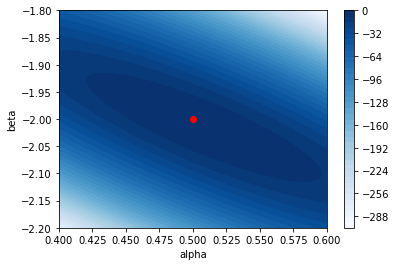

In [12]:
a_i = 0
a_e = 400
b_i =  0
b_e = 400

assert a_i < a_e
assert b_i < b_e 

posterior_2 = posterior_1[np.ix_(np.arange(b_i, b_e), np.arange(a_i, a_e) )]
res = {'alpha': alpha, 'beta': beta, 'posterior': posterior_2, 'param_labels': ["alpha", "beta"], 'true_params': [alpha_true_mean, beta_true_mean]}
plt.contourf(alpha[a_i:a_e], beta[b_i:b_e], posterior_2, cmap='Blues', levels=40, vmin=posterior_2.min(), vmax=posterior_2.max())
# plt.hlines(beta_true_mean, min(alpha), max(alpha))
# plt.vlines(alpha_true_mean, min(beta), max(beta))
plt.plot(alpha_true_mean, beta_true_mean, marker = 'o', zorder=10, color='r')
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')

In [13]:
import pickle as pk
with open('LineFitting/analytical.pk', 'wb') as handle:
    pk.dump(res, handle, protocol=pk.HIGHEST_PROTOCOL)

In [14]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def run_metropolis_hastings(p0, n_steps, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : Initial parameter vector.
    n_steps : Number of steps to run the sampler for.
    model : function to calculate the posterior
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal 
        function. These are like step sizes in each of the parameters.
    """
    p0 = np.array(p0)
    if len(proposal_sigmas) != len(p0):
        raise ValueError("Proposal distribution should have same shape as parameter vector.")
    
    # the objects we'll fill and return:
    chain = np.zeros((n_steps, len(p0))) # parameter values at each step
    ln_probs = np.zeros(n_steps) # log-probability values at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    _, ln_probs[0] = posterior_calc(p0[0], p0[1])
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        _, new_ln_prob = posterior_calc(new_p[0], new_p[1])
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

In [17]:
p0 = [.47, -1.81]
chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=180000, proposal_sigmas=[0.05,0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))

good_samples = chain[2000::8]

Acceptance fraction: 14.4%


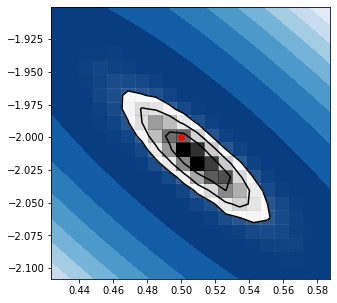

In [19]:
import corner
fig,ax = plt.subplots(1, 1, figsize=(5,5))


a_i = 0
a_e = 400
b_i =  0
b_e = 400

assert a_i < a_e
assert b_i < b_e 

posterior_2 = posterior_1[np.ix_(np.arange(b_i, b_e), np.arange(a_i, a_e) )]
res = {'alpha': alpha, 'beta': beta, 'posterior': posterior_2, 'param_labels': ["alpha", "beta"], 'true_params': [alpha_true_mean, beta_true_mean]}
ax.contourf(alpha[a_i:a_e], beta[b_i:b_e], posterior_2, cmap='Blues', levels=19, vmin=posterior_2.max()-128, vmax=posterior_2.max())
# plt.hlines(beta_true_mean, min(alpha), max(alpha))
# plt.vlines(alpha_true_mean, min(beta), max(beta))
ax.plot(alpha_true_mean, beta_true_mean, marker = 'o', zorder=10, color='r')
# plt.colorbar()
# plt.xlabel('alpha')
# plt.ylabel('beta')
# ax.plot(chain[:512,0], chain[:512,1], marker='', color='k', linewidth=1.)
# ax.plot(chain[17999, 0], chain[17999, 1], marker = 'o', zorder=10, color='b')

corner.hist2d(good_samples[:, 0], good_samples[:, 1], ax = ax, fill_contours=False)